
--- Vorverarbeitung des gesamten Effektgrößen-DataFrames ---
Roh-Effektgrößen-DataFrame erfolgreich geladen von: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/deviation_results_norm_results_HC_0.7_all_20250521_0641_20250526_090143/regional_effect_sizes_vs_HC.csv
DataFrame nach 'neuromorphometrics' gefiltert. Ursprüngliche Zeilen: 924, Gefilterte Zeilen: 408
ROI-Namen bereinigt und normalisiert. Beispielbereinigung:
Original: 'neuromorphometrics_3rd Ventricle_Vgm' -> Bereinigt: '3rd Ventricle'

--- Starte Plotting für folgende Diagnosen: MDD, SCHZ, CTT ---

### Plotting für Diagnose: MDD ###
NeuroMorphometrics Atlas erfolgreich geladen von: /workspace/project/catatonia_VAE-main_bq/data/atlases_niis/neuro_neu.nii
Label-Map XML-Datei erfolgreich geladen von: /workspace/project/catatonia_VAE-main_bq/data/atlases_niis/atlases_labels/1103_3_glm_LabelMap.xml
ROI-Namen aus Label-Map normalisiert.


/tmp/ipykernel_7091/1561223602.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['ROI_Name_Temp'] = df_filtered[raw_roi_name_col].astype(str).apply(
/tmp/ipykernel_7091/1561223602.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['ROI_Name_Cleaned'] = df_filtered['ROI_Name_Temp'].astype(str).apply(
/tmp/ipykernel_7091/1561223602.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst


Warnung: Folgende ROIs aus Ihrem bereinigten DataFrame wurden NICHT im Atlas / in der Label-Map gefunden und nicht geplottet:
- Left AnG angular gyrus (Nicht in Label-Map gefunden)
- Left SCA subcallosal area (Nicht in Label-Map gefunden)
- Left SFG superior frontal gyrus (Nicht in Label-Map gefunden)
- Left SMC supplementary motor cortex (Nicht in Label-Map gefunden)
- Left SMG supramarginal gyrus (Nicht in Label-Map gefunden)
- Left SOG superior occipital gyrus (Nicht in Label-Map gefunden)
- Left SPL superior parietal lobule (Nicht in Label-Map gefunden)
- Left STG superior temporal gyrus (Nicht in Label-Map gefunden)
- Left TMP temporal pole (Nicht in Label-Map gefunden)
- Left TTG transverse temporal gyrus (Nicht in Label-Map gefunden)
- Right AnG angular gyrus (Nicht in Label-Map gefunden)
- Right Cun cuneus (Nicht in Label-Map gefunden)
- Right Ent entorhinal area (Nicht in Label-Map gefunden)
- Right FRP frontal pole (Nicht in Label-Map gefunden)
- Right FuG fusiform gyrus (Ni

AttributeError: 'OrthoSlicer' object has no attribute 'save_img'

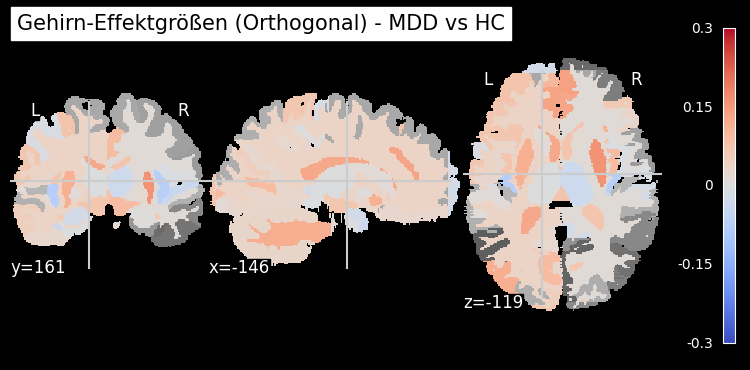

In [ ]:
import os
os.environ["SCIPY_ARRAY_API"] = "1"
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn import plotting
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import re

def normalize_spaces(text):
    """
    Normalisiert Leerzeichen und bereinigt Strings für den Abgleich.
    Ersetzt alle nicht-alphanumerischen Zeichen (außer Leerzeichen) durch Leerzeichen,
    ersetzt alle Unicode-Leerzeichen durch ein Standardleerzeichen,
    entfernt führende/nachfolgende Leerzeichen und ersetzt multiple Leerzeichen durch ein einzelnes.
    """
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        normalized_text = text.replace('\xa0', ' ')
        normalized_text = re.sub(r'\s+', ' ', normalized_text).strip()
        return normalized_text.strip()
    return text


def prepare_effect_sizes_dataframe(effect_sizes_file_path, file_type, raw_roi_name_col, effect_size_col, diagnosis_col, target_atlas_name="neuromorphometrics"):
    """
    Lädt Effektgrößen aus einer Datei, filtert nach Atlasname und bereinigt ROI-Namen.
    Behält die Diagnose-Spalte bei.

    Args:
        effect_sizes_file_path (str): Pfad zur Datei (CSV oder Excel) mit den Effektgrößen.
        file_type (str): Der Typ der Datei ('csv' oder 'excel').
        raw_roi_name_col (str): Der ursprüngliche Name der Spalte mit den unbereinigten ROI-Namen.
        effect_size_col (str): Der Name der Spalte mit den Effektgrößen (z.B. 'Cliffs_Delta').
        diagnosis_col (str): Der Name der Spalte, die die Diagnose enthält (z.B. 'Diagnosis').
        target_atlas_name (str): Der Atlasname, nach dem gefiltert werden soll (z.B. 'neuromorphometrics').

    Returns:
        pd.DataFrame: Ein bereinigter DataFrame mit den Spalten 'ROI_Name_Cleaned', dem Effektgrößen-Namen
                      und der Diagnose, oder None, wenn ein Fehler auftritt.
    """
    try:
        if file_type == 'csv':
            df = pd.read_csv(effect_sizes_file_path)
        elif file_type == 'excel':
            df = pd.read_excel(effect_sizes_file_path)
        else:
            print(f"Fehler: Ungültiger Dateityp '{file_type}'. Bitte 'csv' oder 'excel' verwenden.")
            return None

        print(f"Roh-Effektgrößen-DataFrame erfolgreich geladen von: {effect_sizes_file_path}")

        required_cols = [raw_roi_name_col, effect_size_col, diagnosis_col]
        for col in required_cols:
            if col not in df.columns:
                print(f"Fehler: Spalte '{col}' nicht im DataFrame gefunden.")
                print(f"Verfügbare Spalten: {df.columns.tolist()}")
                return None

        df_filtered = df[df[raw_roi_name_col].astype(str).str.contains(target_atlas_name, na=False, case=False)]
        print(f"DataFrame nach '{target_atlas_name}' gefiltert. Ursprüngliche Zeilen: {len(df)}, Gefilterte Zeilen: {len(df_filtered)}")

        if df_filtered.empty:
            print(f"Keine Zeilen für den Atlas '{target_atlas_name}' gefunden. Überprüfen Sie den 'raw_roi_name_col' und 'target_atlas_name'.")
            return None

        df_filtered['ROI_Name_Temp'] = df_filtered[raw_roi_name_col].astype(str).apply(
            lambda x: x.split(f"{target_atlas_name}_", 1)[1] if f"{target_atlas_name}_" in x else x
        )

        suffixes_to_remove = ['_Vgm', '_Vwm', '_csf']

        df_filtered['ROI_Name_Cleaned'] = df_filtered['ROI_Name_Temp'].astype(str).apply(
            lambda x: x
        )

        for suffix in suffixes_to_remove:
            df_filtered['ROI_Name_Cleaned'] = df_filtered['ROI_Name_Cleaned'].apply(
                lambda x: x.replace(suffix, '') if isinstance(x, str) and x.endswith(suffix) else x
            )

        df_filtered['ROI_Name_Cleaned'] = df_filtered['ROI_Name_Cleaned'].apply(normalize_spaces)

        # Include the diagnosis column here
        cleaned_df = df_filtered[['ROI_Name_Cleaned', effect_size_col, diagnosis_col]].copy()
        cleaned_df.rename(columns={'ROI_Name_Cleaned': 'ROI_Name'}, inplace=True)

        print(f"ROI-Namen bereinigt und normalisiert. Beispielbereinigung:")
        if not cleaned_df.empty and raw_roi_name_col in df.columns:
            example_idx = cleaned_df.index[0]
            original_raw_name_for_example = df.loc[example_idx, raw_roi_name_col]
            cleaned_name_for_example = cleaned_df.loc[example_idx, 'ROI_Name']
            print(f"Original: '{original_raw_name_for_example}' -> Bereinigt: '{cleaned_name_for_example}'")
        else:
            print("Keine bereinigten ROIs zum Anzeigen des Beispiels vorhanden (oder Original-DF leer).")

        return cleaned_df

    except FileNotFoundError:
        print(f"Fehler: Die Effektgrößen-Datei wurde nicht gefunden unter: {effect_sizes_file_path}")
        print("Bitte überprüfe den Pfad und stelle sicher, dass die Datei existiert.")
        return None
    except Exception as e:
        print(f"Fehler beim Laden oder Verarbeiten der Effektgrößen-Datei: {e}")
        return None


def plot_brain_with_effect_sizes_neuromorphometrics(
    atlas_nifti_path,
    label_map_xml_path,
    effect_sizes_df_cleaned,
    roi_name_col_cleaned,
    effect_size_col,
    title_suffix="", # New argument for plot title
    output_filename_prefix="brain_effect_sizes",
    vmax=None,
    cmap='viridis',
    plot_interactive=False):
    """
    Erstellt 3D-Visualisierungen eines NeuroMorphometrics Gehirnatlas mit eingefärbten ROI-Effektgrößen.
    Erwartet einen bereits bereinigten DataFrame für die Effektgrößen.

    Args:
        atlas_nifti_path (str): Pfad zur NIfTI-Datei deines NeuroMorphometrics Gehirnatlas.
        label_map_xml_path (str): Pfad zur XML-Datei, die die Label-Map des Atlases enthält.
        effect_sizes_df_cleaned (pd.DataFrame): Der bereinigte DataFrame mit den Spalten 'ROI_Name' und Effektgrößen.
        roi_name_col_cleaned (str): Name der Spalte im bereinigten DataFrame, die die ROI-Namen enthält (z.B. 'ROI_Name').
        effect_size_col (str): Name der Spalte im DataFrame, die die Effektgrößen enthält.
        title_suffix (str): Suffix, das zum Titel des Plots hinzugefügt wird (z.B. die Diagnose).
        output_filename_prefix (str): Präfix für die Ausgabedatei-Namen (z.B. "brain_effect_sizes").
        vmax (float, optional): Maximalwert für die Farbskala. Wenn None, wird der maximale Effektgröße verwendet.
        cmap (str): Name der Colormap (z.B. 'viridis', 'hot', 'coolwarm').
        plot_interactive (bool): Wenn True, wird ein interaktiver Plot mit nilearn.plotting.view_img() erstellt.
    """

    # 1. NeuroMorphometrics Atlas laden
    try:
        atlas_img = nib.load(atlas_nifti_path)
        atlas_data = atlas_img.get_fdata()
        print(f"NeuroMorphometrics Atlas erfolgreich geladen von: {atlas_nifti_path}")
    except FileNotFoundError:
        print(f"Fehler: Die NIfTI-Datei des Atlases wurde nicht gefunden unter: {atlas_nifti_path}")
        print("Bitte überprüfe den Pfad und stelle sicher, dass die Datei existiert.")
        return
    except Exception as e:
        print(f"Fehler beim Laden des NeuroMorphometrics Atlases: {e}")
        return

    # 2. Label-Map XML-Datei parsen und Leerzeichen normalisieren
    try:
        tree = ET.parse(label_map_xml_path)
        root = tree.getroot()
        print(f"Label-Map XML-Datei erfolgreich geladen von: {label_map_xml_path}")
    except FileNotFoundError:
        print(f"Fehler: Die Label-Map XML-Datei wurde nicht gefunden unter: {label_map_xml_path}")
        print("Bitte überprüfe den Pfad und stelle sicher, dass die Datei existiert.")
        return
    except Exception as e:
        print(f"Fehler beim Parsen der Label-Map XML-Datei: {e}")
        return

    label_map = {}
    for label in root.findall('Label'):
        name = normalize_spaces(label.find('Name').text)
        number = int(label.find('Number').text)
        label_map[name] = number
    print("ROI-Namen aus Label-Map normalisiert.")

    # 3. Ein leeres Gehirnvolumen für die Effektgrößen erstellen
    effect_map_data = np.zeros_like(atlas_data, dtype=float)

    # 4. Effektgrößen den ROI-Nummern zuordnen und in das neue Volumen schreiben
    found_rois = []
    missing_rois = []

    if roi_name_col_cleaned not in effect_sizes_df_cleaned.columns or effect_size_col not in effect_sizes_df_cleaned.columns:
        print(f"Fehler: Die erforderlichen Spalten '{roi_name_col_cleaned}' oder '{effect_size_col}'")
        print("wurden im bereitgestellten DataFrame nicht gefunden. Überprüfen Sie die prepare_function.")
        return

    for index, row in effect_sizes_df_cleaned.iterrows():
        roi_name = str(row[roi_name_col_cleaned])
        effect_size = row[effect_size_col]

        if roi_name in label_map:
            roi_number = label_map[roi_name]
            if np.any(atlas_data == roi_number):
                effect_map_data[atlas_data == roi_number] = effect_size
                found_rois.append(roi_name)
            else:
                missing_rois.append(f"{roi_name} (ROI-Nummer {roi_number} nicht im Atlas gefunden)")
        else:
            missing_rois.append(f"{roi_name} (Nicht in Label-Map gefunden)")

    if missing_rois:
        print(f"\nWarnung: Folgende ROIs aus Ihrem bereinigten DataFrame wurden NICHT im Atlas / in der Label-Map gefunden und nicht geplottet:")
        for roi in missing_rois:
            print(f"- {roi}")
    if found_rois:
        print(f"\nInfo: {len(found_rois)} ROIs aus Ihrem bereinigten DataFrame wurden im Atlas gefunden und werden geplottet.")
    else:
        print("\nKeine der bereinigten ROIs aus Ihrem DataFrame wurde im Atlas gefunden. Bitte überprüfen Sie die ROI-Namen und die Atlas-Nummern.")
        return

    effect_map_img = nib.Nifti1Image(effect_map_data, atlas_img.affine, atlas_img.header)

    if vmax is None:
        max_val = np.max(np.abs(effect_map_data))
        if max_val == 0:
            vmax = 1.0
            print("Info: Alle Effektgrößen sind Null. vmax wurde auf 1.0 gesetzt.")
        else:
            vmax = max_val
            print(f"\nvmax wurde automatisch auf den Maximalwert der absoluten Effektgrößen gesetzt: {vmax:.2f}")

    # --- Only plot Orthogonal and Interactive, remove Glass Brain ---
    print(f"\nErstelle statische orthogonale Visualisierung für {title_suffix}...")
    fig_ortho = plotting.plot_stat_map(
        effect_map_img,
        bg_img=atlas_img,
        display_mode='ortho',
        colorbar=True,
        cmap=cmap,
        vmax=vmax,
        title=f"Gehirn-Effektgrößen (Orthogonal) - {title_suffix}",
        output_file=None # Keep this as None to show directly or save manually
    )
    # Save the orthogonal plot

    plt.show() # Shows the static plot

    # NEU: Interaktiver Plot mit view_img
    if plot_interactive:
        print(f"\nErstelle interaktive 3D-Visualisierung für {title_suffix} (öffnet im Browser oder Inline-Fenster)...")
        interactive_plot = plotting.view_img(
            effect_map_img,
            bg_img=atlas_img,
            colorbar=True,
            cmap=cmap,
            vmax=vmax,
            title=f"Interaktive Effektgrößen-Karte - {title_suffix}"
        )
        print("Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.")
        # Return the plot object so it can be saved outside the function if needed
        return interactive_plot


# Beispiel-Anwendung
if __name__ == '__main__':
    neuro_morphometrics_atlas_path = "/workspace/project/catatonia_VAE-main_bq/data/atlases_niis/neuro_neu.nii"
    label_map_xml_path = '/workspace/project/catatonia_VAE-main_bq/data/atlases_niis/atlases_labels/1103_3_glm_LabelMap.xml'
    my_actual_effect_sizes_csv_path = "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/deviation_results_norm_results_HC_0.7_all_20250521_0641_20250526_090143/regional_effect_sizes_vs_HC.csv"

    # Define the diagnosis column name
    diagnosis_column_name = 'Diagnosis' # <--- Make sure this matches your CSV column name exactly

    print("\n--- Vorverarbeitung des gesamten Effektgrößen-DataFrames ---")
    all_effect_sizes_df = prepare_effect_sizes_dataframe(
        effect_sizes_file_path=my_actual_effect_sizes_csv_path,
        file_type='csv',
        raw_roi_name_col='ROI_Name',
        effect_size_col='Cliffs_Delta',
        diagnosis_col=diagnosis_column_name, # Pass the diagnosis column name
        target_atlas_name="neuromorphometrics"
    )

    if all_effect_sizes_df is not None and not all_effect_sizes_df.empty:
        # Identify unique diagnoses, excluding 'HC'
        norm_diagnosis = 'HC'
        unique_diagnoses = all_effect_sizes_df[diagnosis_column_name].unique()
        diagnoses_to_plot = [d for d in unique_diagnoses if d != norm_diagnosis]

        if not diagnoses_to_plot:
            print(f"Keine anderen Diagnosen als '{norm_diagnosis}' zum Plotten gefunden.")
        else:
            print(f"\n--- Starte Plotting für folgende Diagnosen: {', '.join(diagnoses_to_plot)} ---")
            output_dir = "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots"
            os.makedirs(output_dir, exist_ok=True) # Create output directory if it doesn't exist

            for diagnosis in diagnoses_to_plot:
                print(f"\n### Plotting für Diagnose: {diagnosis} ###")
                df_for_diagnosis = all_effect_sizes_df[all_effect_sizes_df[diagnosis_column_name] == diagnosis].copy()

                if df_for_diagnosis.empty:
                    print(f"Keine Daten für Diagnose '{diagnosis}'. Überspringe Plot.")
                    continue

                # Generate a filename prefix for the current diagnosis
                current_output_prefix = os.path.join(output_dir, f"neuromorphometrics_effect_sizes_{diagnosis.replace(' ', '_')}")

                interactive_viewer = plot_brain_with_effect_sizes_neuromorphometrics(
                    atlas_nifti_path=neuro_morphometrics_atlas_path,
                    label_map_xml_path=label_map_xml_path,
                    effect_sizes_df_cleaned=df_for_diagnosis,
                    roi_name_col_cleaned='ROI_Name',
                    effect_size_col='Cliffs_Delta',
                    title_suffix=f"{diagnosis} vs {norm_diagnosis}", # Title includes diagnosis
                    output_filename_prefix=current_output_prefix,
                    cmap='coolwarm',
                    vmax=0.3,
                    plot_interactive=True # <--- Set to True for interactive plots
                )
                if interactive_viewer:
                    interactive_viewer.save_as_html(f"{current_output_prefix}_interactive.html")
                    print(f"Interaktiver Plot für {diagnosis} gespeichert unter: {current_output_prefix}_interactive.html")

            print("\nAlle Plots abgeschlossen.")
    else:
        print("\nPlotting übersprungen, da es Probleme bei der Vorbereitung des Effektgrößen-DataFrames gab.")